In [407]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import matplotlib as mpl
import requests
import folium
import altair as alt
# import numpy as np
from utils import *
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
%matplotlib inline



In [4]:
def Display_Plot(df:pd.DataFrame, plot_type, axis:pd.DataFrame.axes, title, color):
    if plot_type == "bar":
        # axis.bar(x= df["Year"], height = df["Total Reviews"], color=color, width=2)
        axis.bar(x= df["Year"], height = df["Total Reviews"], color=color)
        for index, col in enumerate(df["Total Reviews"]):
            txt_len = len(str(col))
            axis.annotate(str(col), xy=(index,col), xytext=(-txt_len,txt_len*1.2), textcoords='offset points', rotation=-45)
            
    axis.set_title(title[::-1])
    axis.set_ymargin(0.15)
    axis.set_xticklabels(axis.get_xticklabels(), rotation=90)
    

C:\Users\Daniel Ventura\AppData\Local\Temp\ipykernel_42752\2302187205.py:11: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"data/{cat}.csv")
C:\Users\Daniel Ventura\AppData\Local\Temp\ipykernel_42752\1066901308.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(axis.get_xticklabels(), rotation=90)
C:\Users\Daniel Ventura\AppData\Local\Temp\ipykernel_42752\1066901308.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(axis.get_xticklabels(), rotation=90)
C:\Users\Daniel Ventura\AppData\Local\Temp\ipykernel_42752\1066901308.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(axis.get_xticklabels(), rotation=90)
C:\Users\Daniel Ventura\AppData\Local\Temp\ipykernel_42752\1066901308.py:14: UserWarning: FixedFormatter should only be used together with FixedLocat

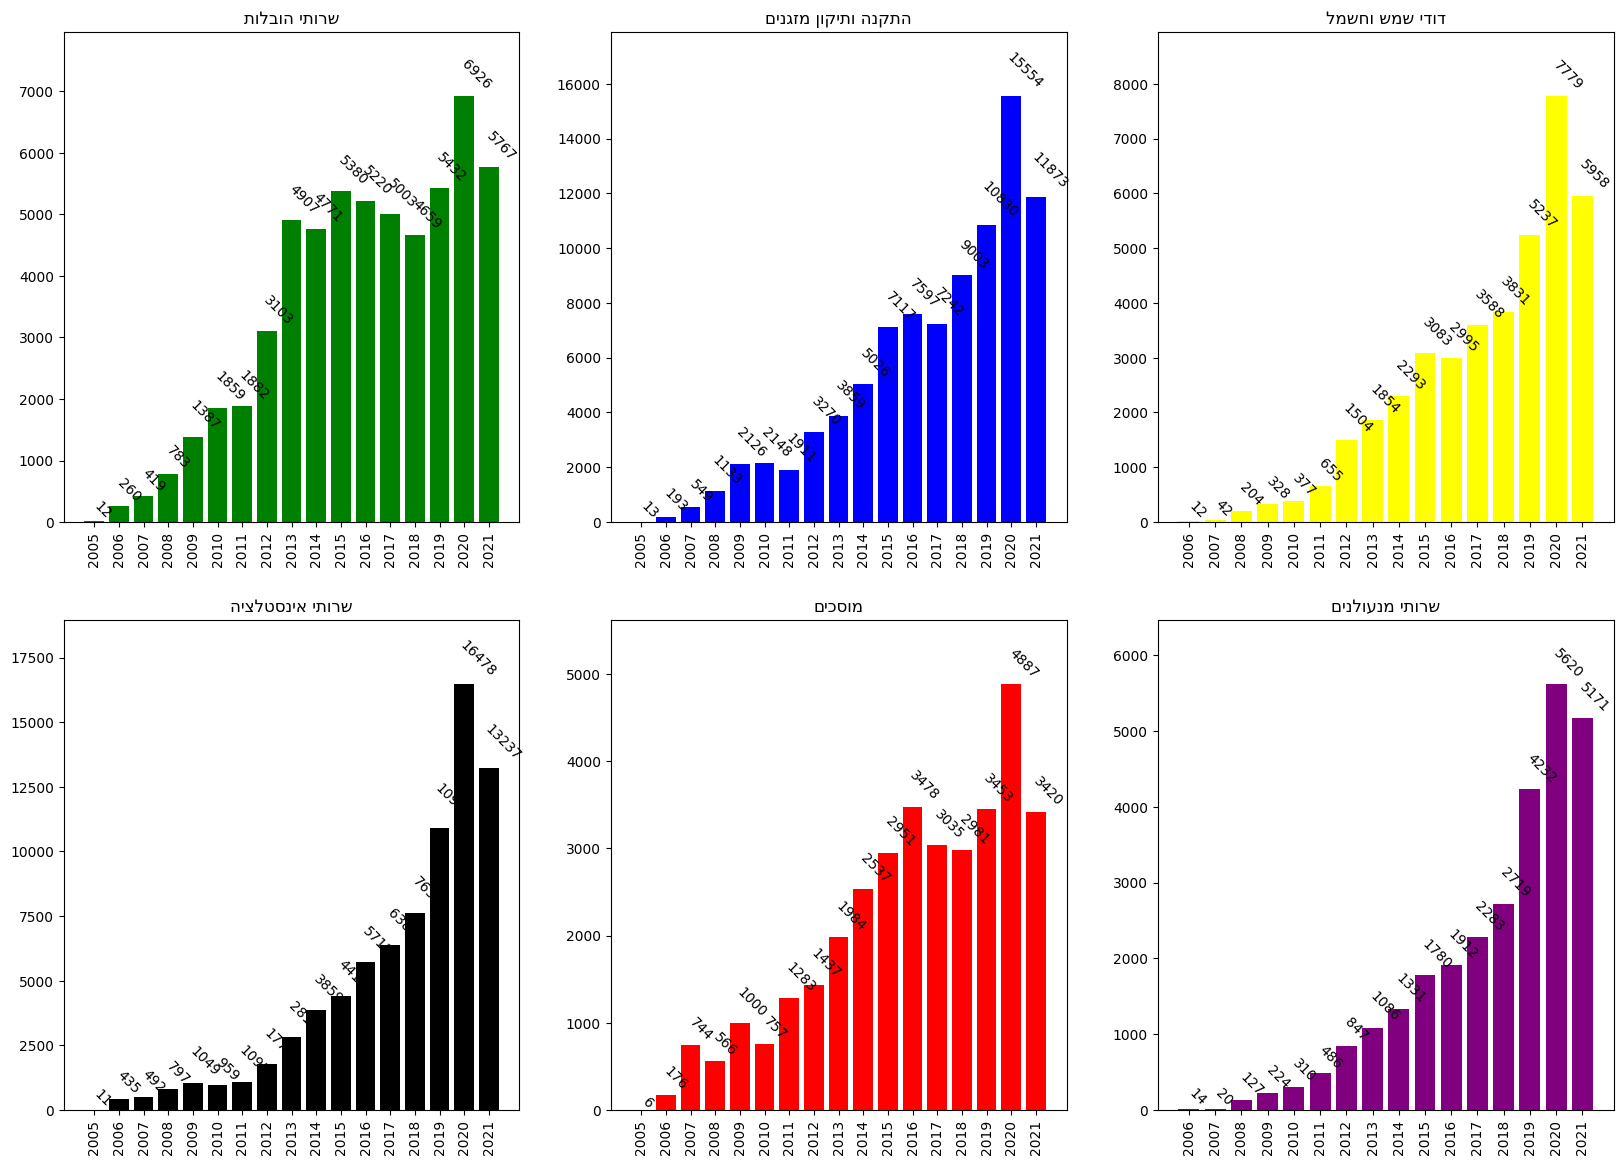

In [89]:
fig, axes = plt.subplots(2,3, figsize=(20,14))
colors = [
    ['green', 'blue','yellow'],
    ['black', 'red', 'purple']
]
# plt.xticks(rotation=90)
categories_csv = Get_All_CSV_Names()
row = 0
index = 0
for cat in categories_csv:
    df = pd.read_csv(f"data/{cat}.csv")
    
    df_dict = pd.DataFrame.from_dict(df["Year"].value_counts().to_dict(), orient="index", columns=["Total Reviews"])
    df_dict.reset_index(inplace=True)
    df_dict.rename(columns={'index':'Year'}, inplace = True)
    df_dict.sort_values(by="Year", inplace=True)
    df_dict['Year'] = df_dict["Year"].astype(str)
    Display_Plot(df_dict, "bar", axes[row, index], cat, colors[row][index])
    
    if index == 2:
        row = 1
        index = 0
    else:
        index+=1
    
    Save_CSV(f"/ML/summery_{cat}.csv", df_dict)

In [34]:
def Display_Graph_Seaborn(df:pd.DataFrame, x_axis, y_axis, hue_title, plot_type, axis:pd.DataFrame.axes, main_title, hue_order):
    if plot_type == 'line':
        sns.lineplot(ax=axis, x=x_axis, y=y_axis, hue=hue_title, hue_order=hue_order, data=df, marker="o", markersize=5)
        axis.set_title(main_title)
        axis.tick_params(labelrotation=90)

C:\Users\Daniel Ventura\AppData\Local\Temp\ipykernel_18932\831689548.py:12: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"data/{csv}.csv")


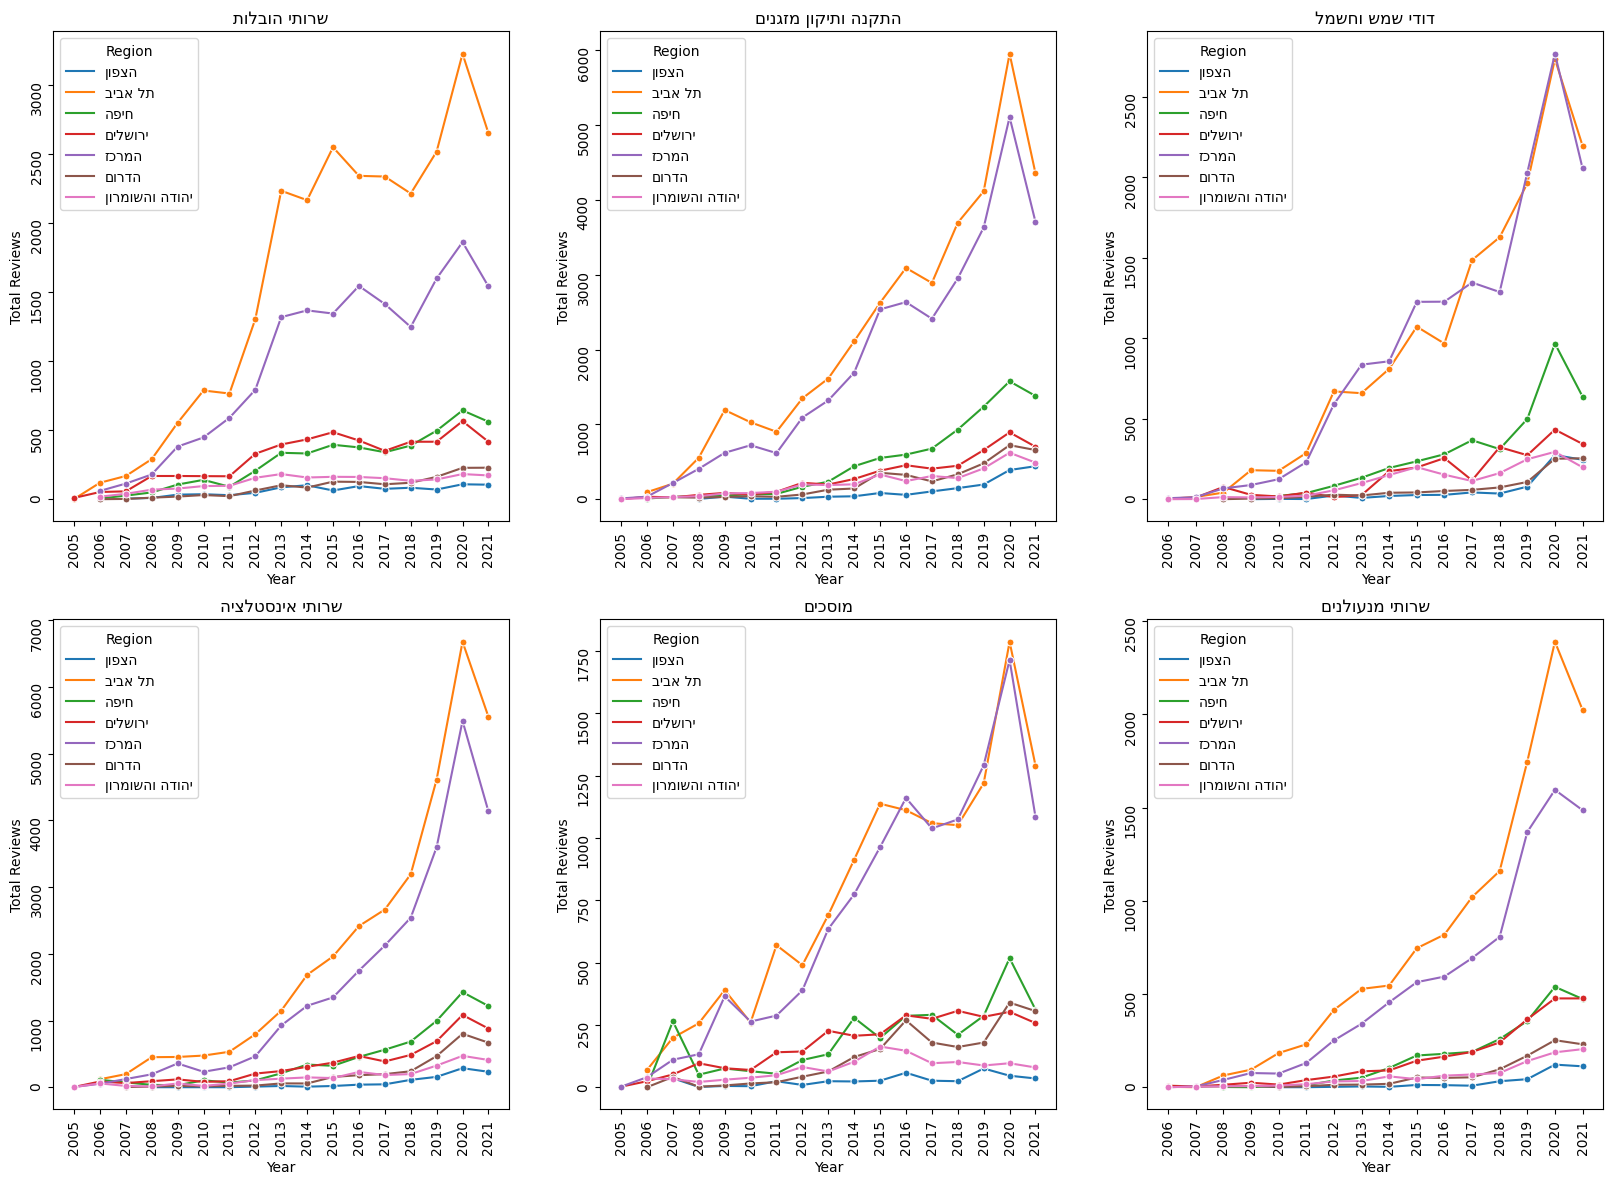

In [36]:
filenames = Get_All_CSV_Names()

fig, axes = plt.subplots(2, 3, figsize=(20, 14))
#fig.suptitle('גידול ענפי שירות לפי איזורים'[::-1])

regions = ['ןופצה', 'ביבא לת', 'הפיח', 'םילשורי', 'זכרמה', 'םורדה', 'ןורמושהו הדוהי']

row = 0
index = 0

for csv in filenames:
    df = pd.read_csv(f"data/{csv}.csv")
    df.drop(df[df.Region == 'חסוי'].index, inplace=True)
    
    df["Year"] = df["Year"].astype(str)
    df["Region"] = df["Region"].apply(lambda x: x[::-1])
    
    grouped = df.groupby([df['Year'], 'Region'])

    reviews_per_year_and_region = grouped['Region'].count().reset_index(name='Total Reviews')
    
    Display_Graph_Seaborn(reviews_per_year_and_region, "Year", "Total Reviews", "Region", 'line', axes[row,index], csv[::-1], regions)

    if index == 2:
        row = 1
        index = 0
    else:
        index+=1




C:\Users\Daniel Ventura\AppData\Local\Temp\ipykernel_42052\1641788544.py:14: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"data/{csv}.csv")
c:\Users\Daniel Ventura\Documents\GitHub\midrag\venv\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['הביס', 'הביסה', 'הדימ', 'הללגבש', 'העשב', 'וב', 'ובש', 'וזיאב', 'וזיאל', 'וזיאמ', 'םוקמ', 'םוקמב', 'םוקמל', 'תילכת'] not in stop_words.
  warnings.warn(
c:\Users\Daniel Ventura\Documents\GitHub\midrag\venv\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['הביס', 'הביסה', 'הדימ', 'הללגבש', 'העשב', 'וב', 'ובש', 'וזיאב', 'וזיאל', 'וזיאמ', 'םוקמ', 'םוקמב', 'םוקמל', 'תילכת'] not in stop_words.
  warnings.warn(


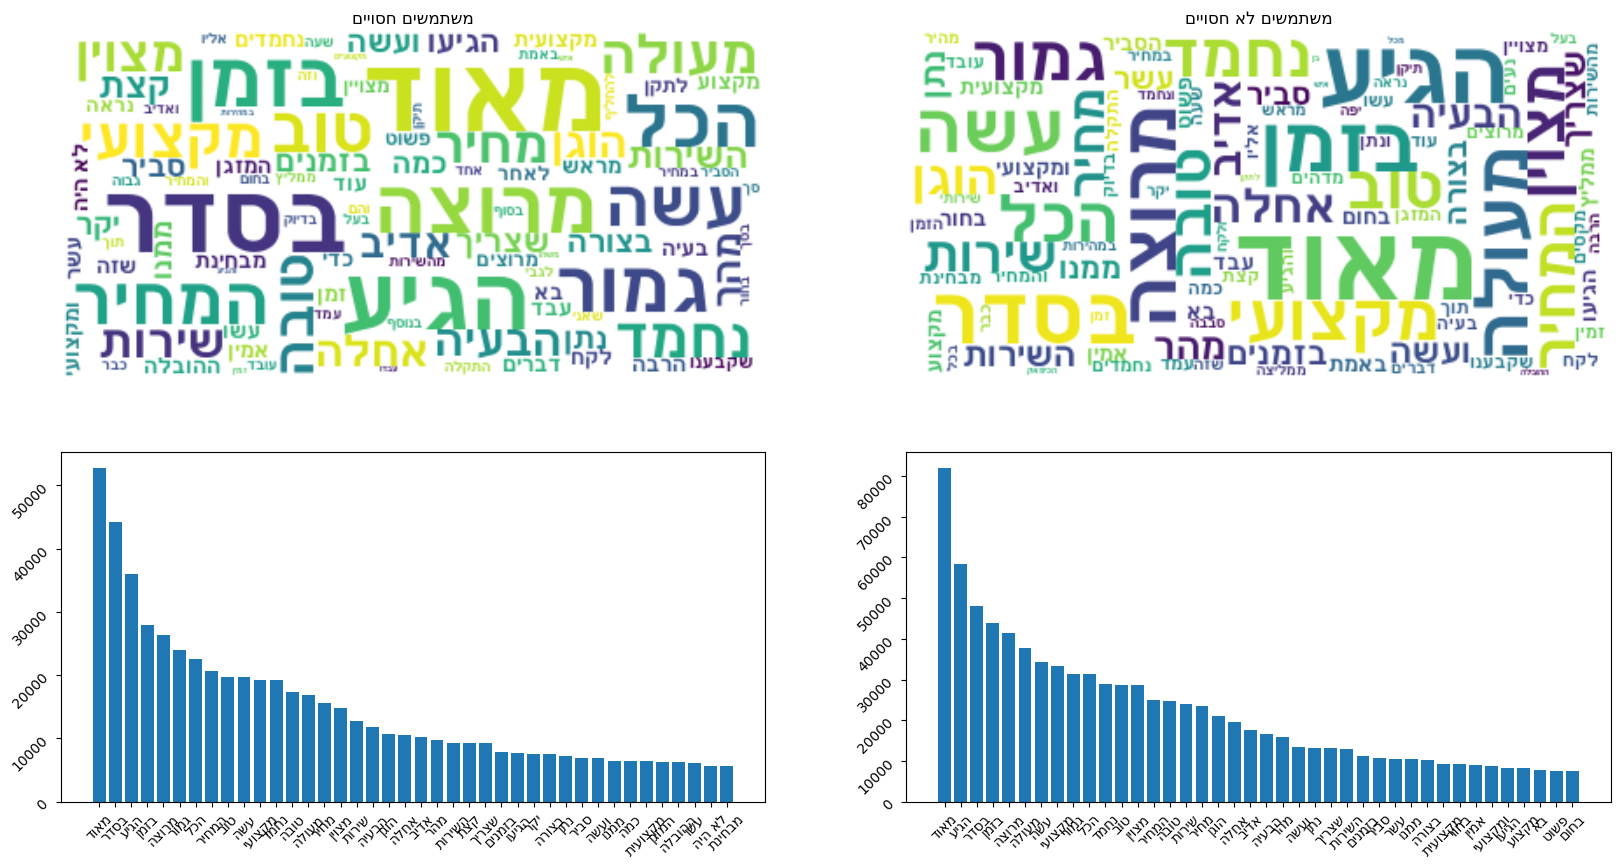

In [87]:
# Check difference between 'חסוי' and visible reviews
#font_path=r'C:\Users\Omer\AppData\Local\Microsoft\Windows\Fonts\FreeSansBold.ttf'
font_path=r'C:\Users\Daniel Ventura\AppData\Local\Microsoft\Windows\Fonts\FreeSansBold.ttf'
stop_words = ['לדעתי', 'העבודה', 'עבודה', 'שהיה', 'שזהו', 'שהם', 'והכל', 'יום', 'הכי', 'והיה', 'והוא', 'שהוא', 'לעשות','אמר', 'ולא', 'ואני', 'דבר','הייתי', 'הייתה', 'צריך', 'וגם', 'אדם', 'היו', 'ממש','שלי','לי','הם','אני', 'את', 'אתה', 'אנחנו', 'אתן', 'אתם', 'הם', 'הן', 'היא', 'הוא', 'שלי', 'שלו', 'שלך', 'שלה', 'שלנו', 'שלכם', 'שלכן', 'שלהם', 'שלהן', 'לי', 'לו', 'לה', 'לנו', 'לכם', 'לכן', 'להם', 'להן', 'אותה', 'אותו', 'זה', 'זאת', 'אלה', 'אלו', 'תחת', 'מתחת', 'מעל', 'בין', 'עם', 'עד', 'נגר', 'על', 'אל', 'מול', 'של', 'אצל', 'כמו', 'אחר', 'אותו', 'בלי', 'לפני', 'אחרי', 'מאחורי', 'עלי', 'עליו', 'עליה', 'עליך', 'עלינו', 'עליכם', 'עליכן', '10','עליהם', 'עליהן', 'כל', 'כולם', 'כולן', 'כך', 'ככה', 'כזה', 'זה', 'זות', 'אותי', 'אותה', 'אותם', 'אותך', 'אותו', 'אותן', 'אותנו', 'ואת', 'את', 'אתכם', 'אתכן', 'איתי', 'איתו', 'איתך', 'איתה', 'איתם', 'איתן', 'איתנו', 'איתכם', 'איתכן', 'יהיה', 'תהיה', 'היתי', 'היתה', 'היה', 'להיות', 'עצמי', 'עצמו', 'עצמה', 'עצמם', 'עצמן', 'עצמנו', 'עצמהם', 'עצמהן', 'מי', 'מה', 'איפה', 'היכן', 'במקום שבו', 'אם', 'לאן', 'למקום שבו', 'מקום בו', 'איזה', 'מהיכן', 'איך', 'כיצד', 'באיזו מידה', 'מתי', 'בשעה ש', 'כאשר', 'כש', 'למרות', 'לפני', 'אחרי', 'מאיזו סיבה', 'הסיבה שבגללה', 'למה', 'מדוע', 'לאיזו תכלית', 'כי', 'יש', 'אין', 'אך', 'מנין', 'מאין', 'מאיפה', 'יכל', 'יכלה', 'יכלו', 'יכול', 'יכולה', 'יכולים', 'יכולות', 'יוכלו', 'יוכל', 'מסוגל', 'לא', 'רק', 'אולי', 'אין', 'לאו', 'אי', 'כלל', 'נגד', 'אם', 'עם', 'אל', 'אלה', 'אלו', 'אף', 'על', 'מעל', 'מתחת', 'מצד', 'בשביל', 'לבין', 'באמצע', 'בתוך', 'דרך', 'מבעד', 'באמצעות', 'למעלה', 'למטה', 'מחוץ', 'מן', 'לעבר', 'מכאן', 'כאן', 'הנה', 'הרי', 'פה', 'שם', 'אך', 'ברם', 'שוב', 'אבל', 'מבלי', 'בלי', 'מלבד', 'רק', 'בגלל', 'מכיוון', 'עד', 'אשר', 'ואילו', 'למרות', 'אס', 'כמו', 'כפי', 'אז', 'אחרי', 'כן', 'לכן', 'לפיכך', 'מאד', 'עז', 'מעט', 'מעטים', 'במידה', 'שוב', 'יותר', 'מדי', 'גם', 'כן', 'נו', 'אחר', 'אחרת', 'אחרים', 'אחרות', 'אשר', 'או']
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

txt_hidden = ""
txt_not_hidden = ""

df_main = pd.DataFrame()
filenames = Get_All_CSV_Names()

for csv in filenames:
    df = pd.read_csv(f"data/{csv}.csv")
    df.Review = df.Review.str.replace(" שלא ", " לא ")
    df.Review = df.Review.str.replace(" ולא ", " לא ")
    df.Review = df.Review.str.replace(" לא ", " 700")

    txt_hidden += df.loc[df["Is Hidden"] == 1].Review.str.cat(sep=' ')
    txt_not_hidden += df.loc[df["Is Hidden"] == 0].Review.str.cat(sep=' ')

txt_hidden = txt_hidden[::-1]
txt_not_hidden = txt_not_hidden[::-1]

for index, word in enumerate(stop_words):
    stop_words[index] = word[::-1]

txt_list = [txt_hidden, txt_not_hidden]
title = ["משתמשים חסויים", "משתמשים לא חסויים"]
index = 0

for txt in txt_list:
    vectorizer=CountVectorizer(stop_words=stop_words)
    freq_vec=vectorizer.fit_transform([txt]).toarray() 
    freqDist=dict(zip(vectorizer.get_feature_names_out(),freq_vec[0])) 
    freqDist=dict(sorted(freqDist.items(), key=lambda item: item[1],reverse=True))

    freqDist = {key.replace('007', ' אל'): value for key, value in freqDist.items()}

    wordcloud = WordCloud(max_font_size=60, max_words=100, background_color="white", font_path=font_path).generate_from_frequencies(freqDist)

    axes[0,index].imshow(wordcloud, interpolation="bilinear")
    axes[0,index].axis("off")
    axes[0,index].set_title(title[index][::-1])

    topK=40
    axes[1,index].bar(list(freqDist.keys())[:topK], list(freqDist.values())[:topK])
    axes[1,index].tick_params(labelrotation=45)

    index += 1

    # for key in freqDist.keys():
    #    if " אל" in key:
    #        print(key[::-1], freqDist[key])

    #print(list(freqDist.keys()), list(freqDist.values()))

array([<AxesSubplot: ylabel='Is Hidden'>], dtype=object)

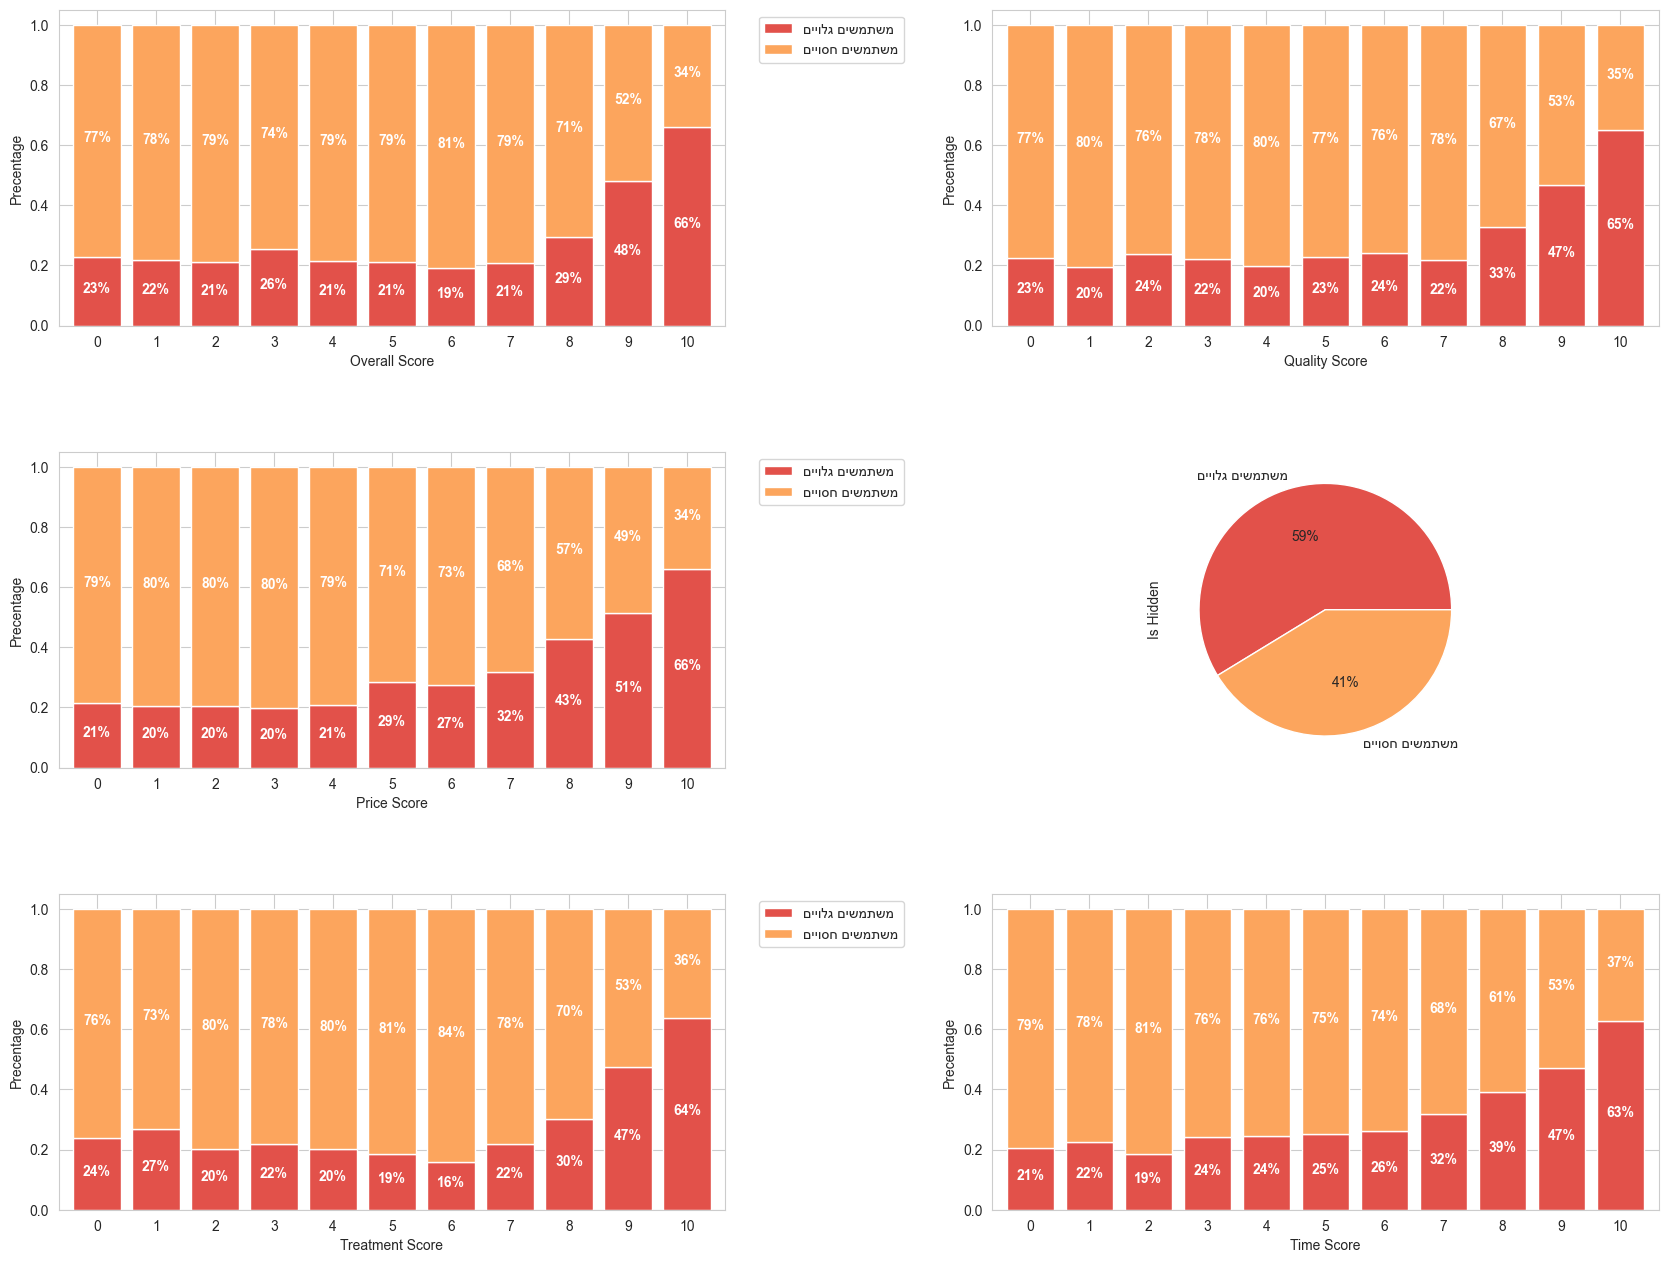

In [324]:
# Check differences between 'משתמשים גלויים' and 'משתמשים חסויים' based on the review's scores (Overall, Quality, Price, Time & Treatment)

filenames = Get_All_CSV_Names()
df_main = pd.DataFrame()

for csv in filenames:
    df_temp = pd.read_csv(f"data/{csv}.csv", usecols=['Overall Score', 'Quality Score', 'Price Score', 'Time Score', 'Treatment Score', 'Is Hidden'])
    df_main = pd.concat([df_main, df_temp])

df_hidden = df_main.loc[df_main["Is Hidden"] == 1]
df_not_hidden = df_main.loc[df_main["Is Hidden"] == 0]

fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
row,index = 0, 0

score_labels = ['Overall Score', 'Quality Score', 'Price Score', 'Time Score', 'Treatment Score']

for score in score_labels:
    
    ct = pd.crosstab(df_main[score], df_main['Is Hidden'], rownames=[score], colnames=['Is Hidden'])
    result = ct.apply(lambda x: x / x.sum(), axis=1)

    # Visualize In Graph

    if index == 0:
        g = result.plot(ax=axes[row,index], kind='bar', stacked=True, width=0.8, figsize=(20, 15))
        g.legend(['משתמשים גלויים'[::-1], 'משתמשים חסויים'[::-1]], loc='best')
        sns.move_legend(g, "upper left", bbox_to_anchor=(1.04, 1))
    else:
        g = result.plot(ax=axes[row,index], kind='bar', stacked=True, width=0.8, figsize=(20, 15), legend=False)

    g.set_xlabel(score)
    g.set_ylabel('Precentage')

    for p in g.containers:
        labels = [f'{h:.0%}' for h in p.datavalues]
        labels = g.bar_label(p, labels=labels, label_type='center', fontsize=10, padding=2)
        for label in labels:
            label.set_color('white')
            label.set_weight('bold')
    
    sns.set_style('whitegrid')
    sns.set_palette('Spectral')
    g.tick_params(axis='x', rotation=0)

    if index == 1:
        row += 1
        index = 0
    else:
        index+=1

df_piechart = pd.DataFrame(df_main["Is Hidden"].value_counts())
df_piechart = df_piechart.rename(index={0:'משתמשים גלויים'[::-1], 1: 'משתמשים חסויים'[::-1]})

temp = axes[1, 1].get_position()
axes[1, 1].set_position(axes[2, 1].get_position())
axes[2, 1].set_position(temp)

df_piechart.plot(ax=axes[2,1], kind='pie', figsize=(20, 15), legend=False, autopct='%1.f%%', subplots=True)

In [ ]:
# Image - Wordcloud

# def transform_format(val):
#     if val != 0:
#         return 255
#     else:
#         return val


# image_file=Image.open("./images/alice.png")
# image_file=image_file.convert('1')
# alice_mask = np.array(image_file)

# transformed_alice_mask = np.ndarray((alice_mask.shape[0],alice_mask.shape[1]), np.int32)

# for i in range(len(alice_mask)):
#     transformed_alice_mask[i] = list(map(transform_format, alice_mask[i]))

# wc = WordCloud(background_color="white", max_words=100, mask=transformed_alice_mask,contour_width=3, contour_color='gray')

# wc=wc.generate_from_frequencies(freqDist)
# plt.figure(figsize=[20,10])
# plt.imshow(wc, interpolation='bilinear')
# plt.axis("off")
# plt.show()

In [423]:
def Dataframe_To_Json(df:pd.DataFrame):
    # convert the dataframe to a dictionary
    review_counts_dict = {'Year': list(df['Year']), 'Reviews Count': list(df['Reviews Count'])}

    # create the JSON structure
    vis_json = {
    "axes":[
        {
            "scale":"x",
            "title":"Year",
            "type":"x"
        },
        {
            "scale":"y",
            "title":"Reviews Count (per year)",
            "type":"y"
        }
    ],
    "data":[
        {
            "name":"table",
            "values":[
                {
                "col":"Reviews Count (per year)",
                "idx":year,
                "val":count
                }
                for year, count in zip(review_counts_dict['Year'], review_counts_dict['Reviews Count'])
            ]
        }
    ],
    "height":200,
    "legends":[],
    "marks":[
        {
            "from":{
                "data":"table",
                "transform":[
                {
                    "keys":[
                        "data.col"
                    ],
                    "type":"facet"
                }
                ]
            },
            "marks":[
                {
                "properties":{
                    "enter":{
                        "stroke":{
                            "field":"data.col",
                            "scale":"color"
                        },
                        "strokeWidth":{
                            "value":2
                        },
                        "x":{
                            "field":"data.idx",
                            "scale":"x"
                        },
                        "y":{
                            "field":"data.val",
                            "scale":"y"
                        }
                    }
                },
                "type":"line"
                }
            ],
            "type":"group"
        }
    ],
    "padding":"auto",
    "scales":[
        {
            "domain":{
                "data":"table",
                "field":"data.idx"
            },
            "name":"x"
        },
        {
            "domain":{
                "data":"table",
                "field":"data.val"
            },
            "name":"y",
            "nice":True,
            "range":"height"
        },
        {
            "domain":{
                "data":"table",
                "field":"data.col"
            },
            "name":"color",
            "range":"category20",
            "type":"ordinal"
        }
    ],
    "width":400
    }

    # convert the JSON to a string and print it
    vis_json_str = json.dumps(vis_json, indent=2)
    return vis_json_str

In [466]:
# Create a Map that takes array of [locations, total_reviews] as an input, gets the Geo-Location of each location (using OpenStreeMap API) and Pin-Points the Top-5 Locations with the most reviews

import requests
import json
import vincent

map = folium.Map(location=[31.786060, 35.200779], zoom_start=7)

df = pd.DataFrame()

for csv in filenames:
    df_temp = pd.read_csv(f"data/{csv}.csv")
    df = pd.concat([df, df_temp])

df['Location'] = df['Location'].astype(str)
# df['Location'] = df['Location'][~df['Location'].str.contains(r'\d')]
places = df['Location'].value_counts().to_dict()

places_dict = []
for location, total_reviews in places.items():
    places_dict.append({'name': location, 'total_reviews': total_reviews})

places_dict= sorted(places_dict, key=lambda x: x['total_reviews'], reverse=True)

for place in places_dict[:1]:
    # popup = folium.Popup(f'<center><font size="2"><b>{place["name"]}</b></font><br><u>ביקורות</u>: {place["total_reviews"]}', max_width=300)

    url = f'https://nominatim.openstreetmap.org/search?q={place["name"]}+Israel&format=json'
    response = requests.get(url).json()
    if response:
        lat = response[0]['lat']
        lon = response[0]['lon']
        
        df_place = df[df['Location'] == place['name']]
        review_counts = pd.DataFrame(df_place['Year'].value_counts().sort_index()).rename(columns={'Year': 'Reviews Count'}).rename_axis('Year').reset_index()
        review_counts['Year'] = review_counts['Year'].astype(str)
        
        line_points = {
            "Year": review_counts['Year'].values.tolist(),
            "Reviews Count": review_counts['Reviews Count'].values.tolist(),
        }

        line_chart = vincent.Line(line_points, iter_idx='Year', width=450, height=250)

        line_chart.axis_titles(x='Year', y='Reviews Count')

        line_json = line_chart.to_json()

        print(line_json)

        # # create the JSON
        # axes = [{"scale": "x", "title": "Year", "type": "x"},
        #         {"scale": "y", "title": "Reviews Count (per year)", "type": "y"}]

        # data = {"name": "table", "values": []}
        # for i, row in review_counts.iterrows():
        #     data["values"].append({"col": "Reviews Count (per year)", "idx": row["Year"], "val": row["Reviews Count"]})

        # result = {"axes": axes, "data": [data]}
        # data = json.dumps(result, indent=4)
        
        # data = Dataframe_To_Json(review_counts)

        # marker = folium.Marker(
        #     location=[lat, lon],
        #     popup=folium.Popup(max_width=0).add_child(
        #         folium.Vega(line_json, width=450, height=250)
        #     ),
        # )

        # marker.add_to(map)

        popup = folium.Popup(max_width=500)
        folium.Vega(line_json, height=300, width=500).add_to(popup)
        folium.Marker([lat, lon], popup=popup).add_to(map)

        

# url = (
#     "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
#     )

# data = json.loads(requests.get(f"{url}/vis1.json").text)

# print(data)

map

{
  "axes": [
    {
      "scale": "x",
      "title": "Year",
      "type": "x"
    },
    {
      "scale": "y",
      "title": "Reviews Count",
      "type": "y"
    }
  ],
  "data": [
    {
      "name": "table",
      "values": [
        {
          "col": "Reviews Count",
          "idx": "2005",
          "val": 2
        },
        {
          "col": "Reviews Count",
          "idx": "2006",
          "val": 241
        },
        {
          "col": "Reviews Count",
          "idx": "2007",
          "val": 448
        },
        {
          "col": "Reviews Count",
          "idx": "2008",
          "val": 843
        },
        {
          "col": "Reviews Count",
          "idx": "2009",
          "val": 1354
        },
        {
          "col": "Reviews Count",
          "idx": "2010",
          "val": 1610
        },
        {
          "col": "Reviews Count",
          "idx": "2011",
          "val": 1668
        },
        {
          "col": "Reviews Count",
          "idx

In [334]:
# Create a Map that takes array of [locations, total_reviews] as an input, gets the Geo-Location of each location (using OpenStreeMap API) and Pin-Points the Top-5 Locations with the most reviews

import requests

map = folium.Map(location=[31.786060, 35.200779], zoom_start=7)

df = pd.DataFrame()

for csv in filenames:
    df_temp = pd.read_csv(f"data/{csv}.csv")
    df = pd.concat([df, df_temp])

df['Location'] = df['Location'].astype(str)
# df['Location'] = df['Location'][~df['Location'].str.contains(r'\d')]
places = df['Location'].value_counts().to_dict()

places_dict = []
for location, total_reviews in places.items():
    places_dict.append({'name': location, 'total_reviews': total_reviews})

places_dict= sorted(places_dict, key=lambda x: x['total_reviews'], reverse=True)

for place in places_dict[:10]:
    popup = folium.Popup(f'<center><font size="2"><b>{place["name"]}</b></font><br><u>ביקורות</u>: {place["total_reviews"]}', max_width=300)

    url = f'https://nominatim.openstreetmap.org/search?q={place["name"]}+Israel&format=json'
    response = requests.get(url).json()
    if response:
        lat = response[0]['lat']
        lon = response[0]['lon']

    folium.Marker(location=[lat, lon], popup=popup).add_to(map)

map

In [12]:
# Checking Population of each Town in Israel (after getting the Geo-Location of them)
# df_towns = pd.read_csv("data\\israel_towns.csv")

# map = folium.Map(location=[31.786060, 35.200779], zoom_start=7)

# for index, row in df_towns.iterrows():
#     if( pd.notnull(row['Geo_lat']) & pd.notnull(row['Geo_lon']) ):
#         popup = folium.Popup(f'<center><font size="2"><b>{row["Name"]}</b></font><br><u>תושבים:</u>: {row["Population"]}', max_width=300)

#         folium.Marker(location=[row["Geo_lat"], row["Geo_lon"]], popup=popup).add_to(map)

# map

In [10]:
# Create a dataframe with city names and their corresponding values
# data = {'city': ['ירושלים', 'Tel Aviv', 'Haifa', 'Petah Tikva', 'Ashdod'],
#         'value': [100, 75, 50, 25, 0]}
# df = pd.DataFrame(data)
 
# # Create a map object
# m = folium.Map(location=[31.0461, 34.8516], zoom_start=8)
 
# # Use the geo.json file to create the choropleth map
# folium.Choropleth(
#     geo_data='data/map/israel-geojson.json',
#     data=df,
#     columns=['city', 'value'],
#     key_on='feature.properties.HEB_NAME',
#     fill_color='YlGn',
#     fill_opacity=0.7,
#     line_opacity=0.2,
#     legend_name='Value'
# ).add_to(m)
 
# # Add a layer control to toggle the choropleth layer on/off
# folium.LayerControl().add_to(m)
 
# Display the map
# m